<a href="https://colab.research.google.com/github/elhamod/IS883/blob/main/Week11/IS883_2024_Memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IS883 Week11: Agents with Memory

1. Use Google Colab for this assignment.

2. **You are NOT allowed to use external or embedded Gen AI for this assignment (except where specifically instructed). However, you may use Google search and other online resources. As per the syllabus, you are required to cite your usage. You are also responsible for understanding the solution and defending it when asked in class.**

3. For each question, fill in the answer in the cell(s) right below it. The answer could be code or text. You can add as many cells as you need for clarity.

4. **Your submission on Blackboard should be the downloaded notebook (i.e., ipynb file). It should be prepopulated with your solution (i.e., the TA and/or instructor need not rerun the notebook to inspect the output). The code, when executed by the TA and/or instructor, should run with no runtime errors.**

#1. In-Class Work

In [ ]:
!pip install langchain langchain_community langchain_openai

In [ ]:
### Get the OpenAI API key
from google.colab import userdata
openai_api_key = userdata.get('MyOpenAIKey')

## 1.1 Conversations with AI

We have seen so far how an agent could be created to assist us by interacting with the extrenal world to retrieve information or take actions. However, there is still a shortcoming for our system: **It has no memory...**

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain.agents import AgentExecutor, create_tool_calling_agent, tool

chat = ChatOpenAI(openai_api_key=openai_api_key, model="gpt-4o-mini")

# Defining the tools
from datetime import date, timedelta, datetime
@tool
def datetoday() -> str:
    """Returns today's date, use this for any \
    questions that need today's date to be answered. \
    This tool takes no argumetns but returns a string with today's date.""" #This is the desciption the agent uses to determine whether to use the time tool.
    return "Today is " + str(date.today())

tools = [datetoday]

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant."),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"), # To be used by the agent for intermediate operations.
    ]
)
agent = create_tool_calling_agent(chat, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose= True, stream_runnable=False) # stream_runnable=False is needed if you plan to use get_openai_callback()

Let's try to teach an agent my name...

In [ ]:
from langchain.callbacks import get_openai_callback

with get_openai_callback() as cb:
    print(agent_executor.invoke({"input":"What's my name?"}))
    print(cb)

with get_openai_callback() as cb:
    print(agent_executor.invoke({"input":"My name is Batman"}))
    print(cb)

with get_openai_callback() as cb:
    print(agent_executor.invoke({"input":"What's my name?"}))
    print(cb)



> Entering new AgentExecutor chain...
I'm sorry, but I don't have access to your personal information, including your name. If you would like to share your name, I can address you accordingly!

> Finished chain.
{'input': "What's my name?", 'output': "I'm sorry, but I don't have access to your personal information, including your name. If you would like to share your name, I can address you accordingly!"}
Tokens Used: 110
	Prompt Tokens: 77
	Completion Tokens: 33
Successful Requests: 1
Total Cost (USD): $3.135e-05


> Entering new AgentExecutor chain...
Hello, Batman! How can I assist you today?

> Finished chain.
{'input': 'My name is Batman', 'output': 'Hello, Batman! How can I assist you today?'}
Tokens Used: 89
	Prompt Tokens: 77
	Completion Tokens: 12
Successful Requests: 1
Total Cost (USD): $1.875e-05


> Entering new AgentExecutor chain...
I don't have access to your name. If you'd like, you can tell me your name!

> Finished chain.
{'input': "What's my name?", 'output': "I do

To resolve this situation, we need to add a memory to our agent so it **retains the entire conversation and sends it in its entirity** to the language model to get a full response.

The most basic form of `LangChain` memory is [`ConversationBufferMemory`](https://python.langchain.com/v0.1/docs/modules/memory/types/buffer/). It will just keep adding messages to the chat history...

In [ ]:
from langchain.memory import ConversationBufferMemory

# Creates a memory variable called chat_history
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

from langchain_core.prompts import ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant."),
        ("placeholder", "{chat_history}"), #NEW: To retain chat message history.
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"), # To be used by the agent for intermediate tool operations.
    ]
)

agent = create_tool_calling_agent(chat, tools, prompt)

# Now we add the memory object to the agent executor
agent_executor = AgentExecutor(agent=agent, tools=tools,  memory=memory, stream_runnable=False, handle_parsing_errors=True)  # , verbose= True

In [ ]:
with get_openai_callback() as cb:
    print(agent_executor.invoke({"input":"What's my name?"},))
    print(cb)

with get_openai_callback() as cb:
    print(agent_executor.invoke({"input":"My name is Batman"}))
    print(cb)

with get_openai_callback() as cb:
    print(agent_executor.invoke({"input":"What's my name?"}))
    print(cb)


{'input': "What's my name?", 'chat_history': [HumanMessage(content="What's my name?", additional_kwargs={}, response_metadata={}), AIMessage(content="I'm sorry, but I don't have access to your personal information, including your name. However, if you tell me your name, I can remember it for this conversation!", additional_kwargs={}, response_metadata={})], 'output': "I'm sorry, but I don't have access to your personal information, including your name. However, if you tell me your name, I can remember it for this conversation!"}
Tokens Used: 112
	Prompt Tokens: 77
	Completion Tokens: 35
Successful Requests: 1
Total Cost (USD): $3.255e-05
{'input': 'My name is Batman', 'chat_history': [HumanMessage(content="What's my name?", additional_kwargs={}, response_metadata={}), AIMessage(content="I'm sorry, but I don't have access to your personal information, including your name. However, if you tell me your name, I can remember it for this conversation!", additional_kwargs={}, response_metadat

Let's take a look at how the memory grows as we have a longer conversation with our agent.

In [ ]:
import pandas as pd

# A function to make our experiments easier. Prints each question, its response, cost, and total number of tokens. The results are added to a dataframe.
def agent_profiler(input_string, llm="vanilla"): #llm="agent"
  global cumulative_cost
  global cumulative_costs
  global df
  global costs
  global tokens
  with get_openai_callback() as cb:
      if llm == "vanilla":
        response = chat.invoke(input_string).content
      else:
        response = agent_executor.invoke({"input": input_string})["output"]

      # Create a new row as a dictionary
      new_row = {
          'question': input_string,
          'response': response,
          'cost': cb.total_cost,
          'tokens': cb.total_tokens
      }
      # Append the new row to the DataFrame
      df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

      cumulative_cost = cumulative_cost + cb.total_cost
      # cost_over_time.append(cumulative_cost)
      tokens.append(cb.total_tokens)
      costs.append(cb.total_cost)
      cumulative_costs.append(cumulative_cost)

### IMPORTANT: Make sure to reset these variables for each experiment
def reset_experiment():
  global cumulative_cost
  global cumulative_costs
  global df
  global costs
  global tokens
  cumulative_cost = 0
  costs=[]
  cumulative_costs=[]
  tokens=[]
  df = pd.DataFrame(columns=['question', 'response', 'cost', 'tokens'])

Reset the experiment whenever you start a new one.

In [ ]:
reset_experiment()

Run the experiment

In [ ]:
# agent_profiler("You are my Buttler, Alfred")
# agent_profiler("Where are you now?")
# agent_profiler("Write a poem about the adventures of Batman and Joker in 400 words")
# agent_profiler("No, my age is 39")
# agent_profiler("Who is my son?")
# agent_profiler("What's my name?")
# agent_profiler("How old am I?")

agent_profiler("You are my Buttler, Alfred", llm="agent")
agent_profiler("Where are you now?", llm="agent")
agent_profiler("Write a poem about the adventures of Batman and Joker in 400 words", llm="agent")
agent_profiler("No, my age is 39", llm="agent")
agent_profiler("Who is my son?", llm="agent")
agent_profiler("What's my name?", llm="agent")
agent_profiler("How old am I?", llm="agent")



print("Total cost", cumulative_cost)
df

Total cost 0.005214


,question,response,cost,tokens
0,"You are my Buttler, Alfred","Of course, Master Batman! How may I assist you...",0.000035,190
1,Where are you now?,"I am right here, ready to assist you with anyt...",0.000052,238
2,Write a poem about the adventures of Batman an...,**Title: The Eternal Dance**\n\nIn Gotham’s sh...,0.000339,759
3,"No, my age is 39","Thank you for sharing, Batman! You're 39 years...",0.000132,799
4,Who is my son?,I don't have access to personal information ab...,0.000142,845
5,What's my name?,Your name is Batman!,0.000132,862
6,How old am I?,You are 39 years old.,0.000136,882
7,"You are my Buttler, Alfred","Absolutely, Master Batman! How may I assist yo...",0.000156,932
8,Where are you now?,"I am here with you, Master Batman, ready to as...",0.000166,984
9,Write a poem about the adventures of Batman an...,**Title: The Eternal Game**\n\nIn Gotham's hea...,0.000437,1482


Plot the trend over time

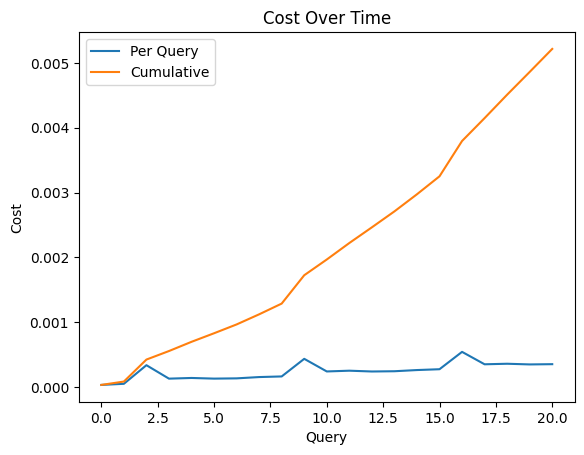

In [ ]:
import matplotlib.pyplot as plt

plt.plot(costs, label='Per Query')
plt.plot(cumulative_costs, label='Cumulative')
plt.xlabel("Query")
plt.ylabel("Cost")
plt.title("Cost Over Time")
plt.legend()
plt.show()


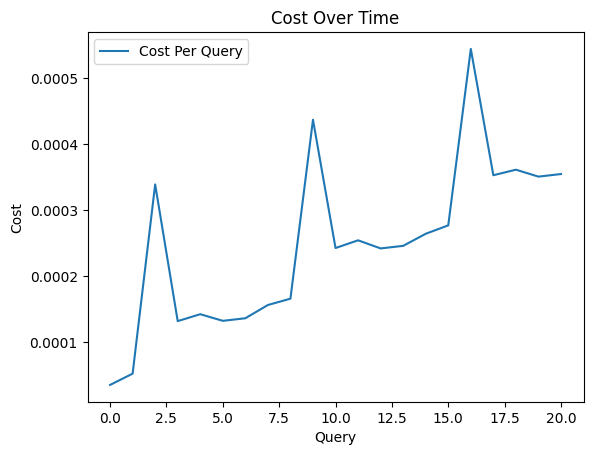

In [ ]:
import matplotlib.pyplot as plt

plt.plot(costs, label='Cost Per Query')
plt.xlabel("Query")
plt.ylabel("Cost")
plt.title("Cost Over Time")
plt.legend()
plt.show()


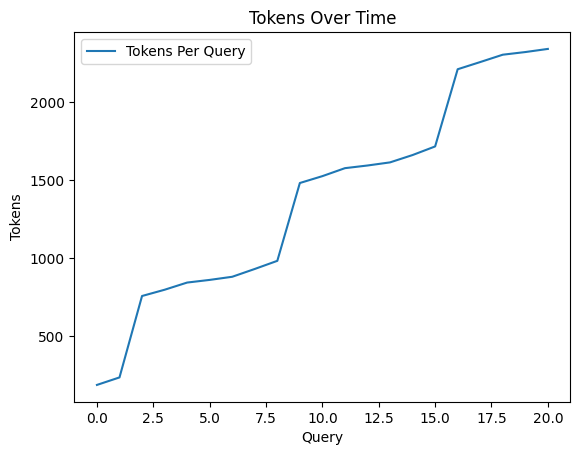

In [ ]:
import matplotlib.pyplot as plt

plt.plot(tokens, label='Tokens Per Query')
plt.xlabel("Query")
plt.ylabel("Tokens")
plt.title("Tokens Over Time")
plt.legend()
plt.show()


You may repeat the two cells above without resetting the experiment (**i.e., without calling `reset_experiment` multiple times**). You will then be able to see the long-term behavior of the chat history.

We can print the memeory content like this

In [ ]:
memory.buffer

[HumanMessage(content="What's my name?", additional_kwargs={}, response_metadata={}),
 AIMessage(content="I don't have access to your personal information, so I don't know your name. You can tell me, and I'll remember it for the duration of our conversation!", additional_kwargs={}, response_metadata={}),
 HumanMessage(content='My name is Batman', additional_kwargs={}, response_metadata={}),
 AIMessage(content='Nice to meet you, Batman! How can I assist you today?', additional_kwargs={}, response_metadata={}),
 HumanMessage(content="What's my name?", additional_kwargs={}, response_metadata={}),
 AIMessage(content='Your name is Batman. How can I help you today, Batman?', additional_kwargs={}, response_metadata={})]

##1.2 Conversation with AI: Cost-Concious Option

##1.3 Streamlit Chatbot



*   Github: https://github.com/elhamod/IS883-chatbot-template/blob/main/streamlit_app.py
*   App: https://chatbotis883template.streamlit.app/



Obviously, the content of the history keeps growing, adding substantial cost to our service. We need to account for such customer behavior...

What if we set a limit on the amount of queries/responses we buffer? We can do that using [`ConversationBufferWindowMemory`](https://python.langchain.com/v0.1/docs/modules/memory/types/buffer_window/)

In [ ]:
from langchain.memory import ConversationBufferWindowMemory

max_number_of_exchanges = 2
memory = ConversationBufferWindowMemory(memory_key="chat_history", k=max_number_of_exchanges, return_messages=True)

# Now we add the memory object to the agent executor
agent_executor = AgentExecutor(agent=agent, tools=tools,  memory=memory, stream_runnable=False, handle_parsing_errors=True)  # , verbose= True

In [ ]:
with get_openai_callback() as cb:
    print(agent_executor.invoke({"input":"What's my name?"},))
    print(cb)

with get_openai_callback() as cb:
    print(agent_executor.invoke({"input":"My name is Batman"}))
    print(cb)

with get_openai_callback() as cb:
    print(agent_executor.invoke({"input":"What's my name?"}))
    print(cb)


{'input': "What's my name?", 'chat_history': [], 'output': "I'm sorry, but I don't know your name. You can tell me if you'd like!\n```"}
Tokens Used: 443
	Prompt Tokens: 407
	Completion Tokens: 36
Successful Requests: 1
Total Cost (USD): $8.264999999999999e-05
{'input': 'My name is Batman', 'chat_history': [HumanMessage(content="What's my name?", additional_kwargs={}, response_metadata={}), AIMessage(content="I'm sorry, but I don't know your name. You can tell me if you'd like!\n```", additional_kwargs={}, response_metadata={})], 'output': 'Nice to meet you, Batman! How can I assist you today?\n```'}
Tokens Used: 488
	Prompt Tokens: 456
	Completion Tokens: 32
Successful Requests: 1
Total Cost (USD): $8.759999999999999e-05
{'input': "What's my name?", 'chat_history': [HumanMessage(content="What's my name?", additional_kwargs={}, response_metadata={}), AIMessage(content="I'm sorry, but I don't know your name. You can tell me if you'd like!\n```", additional_kwargs={}, response_metadata={

In [ ]:
reset_experiment()

In [ ]:
agent_profiler("You are my Buttler, Alfred", llm="agent")
agent_profiler("Where are you now?", llm="agent")
agent_profiler("Write a poem about the adventures of Batman and Joker in 400 words", llm="agent")
agent_profiler("No, my age is 39", llm="agent")
agent_profiler("Who is my son?", llm="agent")
agent_profiler("What's my name?", llm="agent")
agent_profiler("How old am I?", llm="agent")



print("Total cost", cumulative_cost)
df

Total cost 0.006035699999999999


,question,response,cost,tokens
0,"You are my Buttler, Alfred","Of course, Master Bruce! How may I assist you ...",0.000093,522
1,Where are you now?,"I exist in the digital realm, so I don't occup...",0.000106,545
2,Write a poem about the adventures of Batman an...,"In Gotham's shadows, where darkness dwells, \...",0.000379,1031
3,"No, my age is 39",Thank you for sharing that! If there's anythin...,0.000189,1132
4,Who is my son?,I don't have information about your son. If yo...,0.000189,1122
5,What's my name?,I don't have information about your name. If y...,0.000105,567
6,How old am I?,I don't have information about your age. If yo...,0.000105,565
7,"You are my Buttler, Alfred","Of course, Master! How may I assist you today?...",0.000097,554
8,Where are you now?,"As a virtual assistant, I exist in the digital...",0.000105,558
9,Write a poem about the adventures of Batman an...,"In Gotham's shadows, where legends roam, \nA ...",0.000394,1050


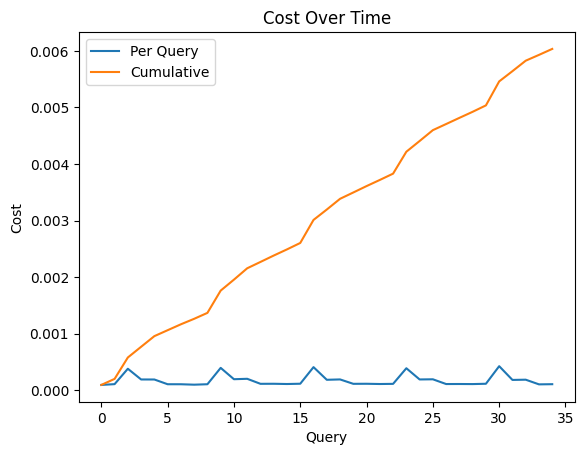

In [ ]:
import matplotlib.pyplot as plt

plt.plot(costs, label='Per Query')
plt.plot(cumulative_costs, label='Cumulative')
plt.xlabel("Query")
plt.ylabel("Cost")
plt.title("Cost Over Time")
plt.legend()
plt.show()

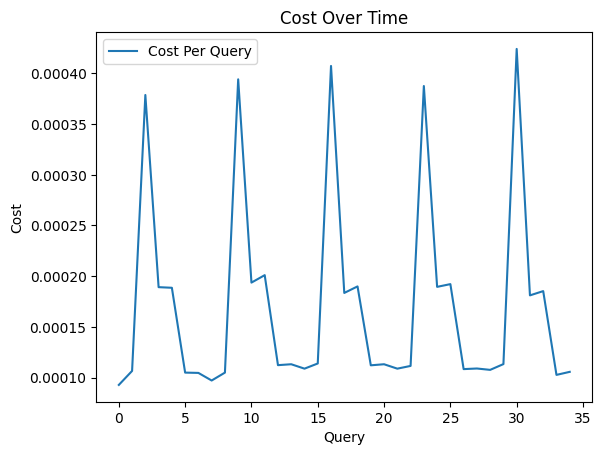

In [ ]:
import matplotlib.pyplot as plt

plt.plot(costs, label='Cost Per Query')
plt.xlabel("Query")
plt.ylabel("Cost")
plt.title("Cost Over Time")
plt.legend()
plt.show()

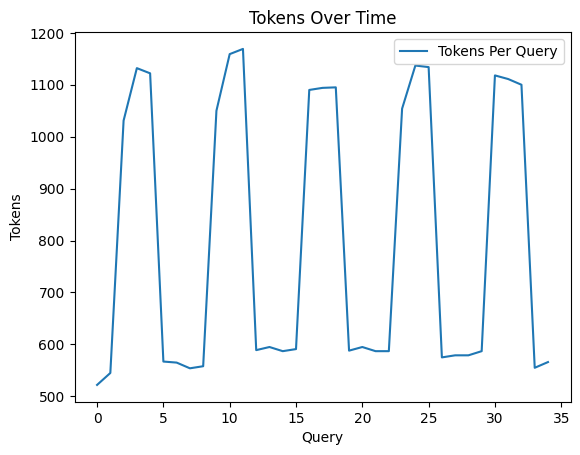

In [ ]:
import matplotlib.pyplot as plt

plt.plot(tokens, label='Tokens Per Query')
plt.xlabel("Query")
plt.ylabel("Tokens")
plt.title("Tokens Over Time")
plt.legend()
plt.show()

In [ ]:
memory.buffer

[HumanMessage(content='My name is Batman', additional_kwargs={}, response_metadata={}),
 AIMessage(content='Nice to meet you, Batman! How can I assist you today?', additional_kwargs={}, response_metadata={}),
 HumanMessage(content="What's my name?", additional_kwargs={}, response_metadata={}),
 AIMessage(content='Your name is Batman!', additional_kwargs={}, response_metadata={})]

**Question:**

Is the model able to answer the questions about age and name? Why or why not? If not, what could be done to improve the situation?

*Answer:*

Notice that when `ConversationBufferMemory` is used, the cost becaomes prohibitive unnecessarily.

Notice that when `ConversationBufferWindowMemory` is used, the cost is much lower, but the there is still the issue of deciding how many exchanges to retain in the chat history. Too little, and you won't get the desired answers. Too many, and the cost will be high.

What can be done about this?...

# 2. Homework

##2.1 Conversation with AI: A Smarter Chat History

To retain information from the chat history but not grow its number of contents quickly, we may use [`ConversationSummaryBufferMemory`](https://api.python.langchain.com/en/latest/memory/langchain.memory.summary_buffer.ConversationSummaryBufferMemory.html), which, instead of preserving the chat history verbatim, *summarizes* its content and appends it as context for the LLM.

You will now perform the following:

1.   Use `ConversationSummaryBufferMemory` instead of the memory types shown
previously to `create_react_agent`. **(5 Points)**


In [ ]:
from langchain.memory import ConversationSummaryBufferMemory
from langchain.agents import AgentExecutor, create_react_agent
from langchain import hub


### FILL CODE HERE to create the memory object.

###

from langchain_core.prompts import ChatPromptTemplate
prompt = prompt = hub.pull("hwchase17/react-chat-json") ### This is a ReAct prompt that works for chat (i.e., when chat history is needed)

agent = create_react_agent(chat, tools, prompt)

# Now we add the memory object to the agent executor
agent_executor = AgentExecutor(agent=agent, tools=tools,  memory=memory, stream_runnable=False, handle_parsing_errors=True)  # , verbose= True

In [ ]:
import langchain
langchain.debug = False

with get_openai_callback() as cb:
    print(agent_executor.invoke({"input":"What's my name?"},))
    print(cb)

with get_openai_callback() as cb:
    print(agent_executor.invoke({"input":"My name is Batman"}))
    print(cb)

with get_openai_callback() as cb:
    print(agent_executor.invoke({"input":"What's my name?"}))
    print(cb)


{'input': "What's my name?", 'chat_history': [HumanMessage(content="What's my name?", additional_kwargs={}, response_metadata={}), AIMessage(content='I don\'t have access to personal information about you, including your name. You can tell me your name if you\'d like, or I can just refer to you as "User."\n```', additional_kwargs={}, response_metadata={})], 'output': 'I don\'t have access to personal information about you, including your name. You can tell me your name if you\'d like, or I can just refer to you as "User."\n```'}
Tokens Used: 460
	Prompt Tokens: 407
	Completion Tokens: 53
Successful Requests: 1
Total Cost (USD): $9.284999999999998e-05
{'input': 'My name is Batman', 'chat_history': [HumanMessage(content="What's my name?", additional_kwargs={}, response_metadata={}), AIMessage(content='I don\'t have access to personal information about you, including your name. You can tell me your name if you\'d like, or I can just refer to you as "User."\n```', additional_kwargs={}, res


2.   Using the same *Batman* chat messages we profiled in 1.1 and 1.2 to profile this new memory type. This includes showing the number of tokens, cost per query, and cummulative cost for a chat of at least 35 exchanges. How does the new memory type perform? How does its performance compare to that of `ConversationBufferWindowMemory` and `ConversationBufferMemory` **(5 Points)**




In [ ]:
reset_experiment()

In [ ]:
agent_profiler("You are my Buttler, Alfred", llm="agent")
agent_profiler("Where are you now?", llm="agent")
agent_profiler("Write a poem about the adventures of Batman and Joker in 400 words", llm="agent")
agent_profiler("No, my age is 39", llm="agent")
agent_profiler("Who is my son?", llm="agent")
agent_profiler("What's my name?", llm="agent")
agent_profiler("How old am I?", llm="agent")



print("Total cost", cumulative_cost)
df

In [ ]:
import matplotlib.pyplot as plt

plt.plot(costs, label='Per Query')
plt.plot(cumulative_costs, label='Cumulative')
plt.xlabel("Query")
plt.ylabel("Cost")
plt.title("Cost Over Time")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(costs, label='Cost Per Query')
plt.xlabel("Query")
plt.ylabel("Cost")
plt.title("Cost Over Time")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(tokens, label='Tokens Per Query')
plt.xlabel("Query")
plt.ylabel("Tokens")
plt.title("Tokens Over Time")
plt.legend()
plt.show()

*Answer:*

Leave answer here.


3.   After playing with `ConversationSummaryBufferMemory` (i.e., running long conversation), what is unique about the way it is formulating its requests compared to the other types? Explain how you reached your diagnosis and conclusion. **(3 Points)**


*Answer:*

Leave answer here.

4. After playing with this new type of memory, would you say it is *always better* than `ConversationBufferMemory`? What is your argument for or against this statement? Demonstrate your point clearly with examples involving 1) `max_token_limit` and 2) the number of exchanges. **(5 Points)**

*Answer:*

Leave answer here.